# Segmentación de imágenes (CamVid) con **HRNet** + TensorFlow Hub

En este Colab dejo un flujo **simple y reproducible** para hacer segmentación semántica usando un modelo pre-entrenado.

**La idea:**
- Descargo unas imágenes de ejemplo (CamVid).
- Corro inferencia con **HRNet** desde TensorFlow Hub.
- Hago el post-procesado: saco *background*, hago `argmax` por pixel y lo paso a colores.

> Nota: si usas Colab, con GPU es mas cómodo, pero también corre en CPU (solo que más lento).


## Contenido
1. Setup e imports
2. Descargar imágenes de ejemplo
3. Mapa de clases (32 clases)
4. Cargar modelo (TF Hub)
5. Inferencia y post-procesado
6. Visualización (máscara en color + overlay)
7. Predicciones sobre varias imágenes
8. Conclusión


## 1) Setup e imports

In [17]:
import os
import zipfile
import requests
import glob

import numpy as np
import cv2

import tensorflow as tf
import tensorflow_hub as hub

import matplotlib.pyplot as plt

import warnings
import logging
import absl

warnings.filterwarnings("ignore", module="absl")

logging.captureWarnings(True)

absl_logger = logging.getLogger("absl")
absl_logger.setLevel(logging.ERROR)

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

## 2) Descargar imágenes de ejemplo

Para no depender de un dataset enorme, voy a bajar un ZIP con algunas imágenes del estilo CamVid.


In [20]:
# Descarga y unzip
SAMPLE_ZIP_URL = "https://www.dropbox.com/s/5jhbvmqgzbzl9fd/camvid_images.zip?dl=1"
SAMPLE_ZIP_NAME = "camvid_images.zip"
SAMPLE_DIR = "camvid_images"


def download_file(url: str, save_name: str) -> None:
    r = requests.get(url, stream=True, timeout=60)
    r.raise_for_status()
    with open(save_name, "wb") as f:
        for chunk in r.iter_content(chunk_size=1024 * 1024):
            if chunk:
                f.write(chunk)


def unzip(zip_path: str, dst: str = ".") -> None:
    with zipfile.ZipFile(zip_path, "r") as z:
        z.extractall(dst)


if not os.path.exists(SAMPLE_ZIP_NAME):
    print("Descargando ZIP...")
    download_file(SAMPLE_ZIP_URL, SAMPLE_ZIP_NAME)
else:
    print("ZIP ya existe, nobajar")

if not os.path.exists(SAMPLE_DIR):
    print("Descomprimiendo...")
    unzip(SAMPLE_ZIP_NAME)
else:
    print("Carpeta ya existe")


Descargando ZIP...
Carpeta ya existe


## 3) Cargar y visualizar imágenes

Leo las imágenes, las paso a **RGB**, las normalizo a **[0, 1]** y agrego dimensión de batch para alimentar al modelo.


Cantidad de imágenes: 4
Rutas: ['camvid_images/camvid_sample_1.png', 'camvid_images/camvid_sample_2.png', 'camvid_images/camvid_sample_3.png', 'camvid_images/camvid_sample_4.png']


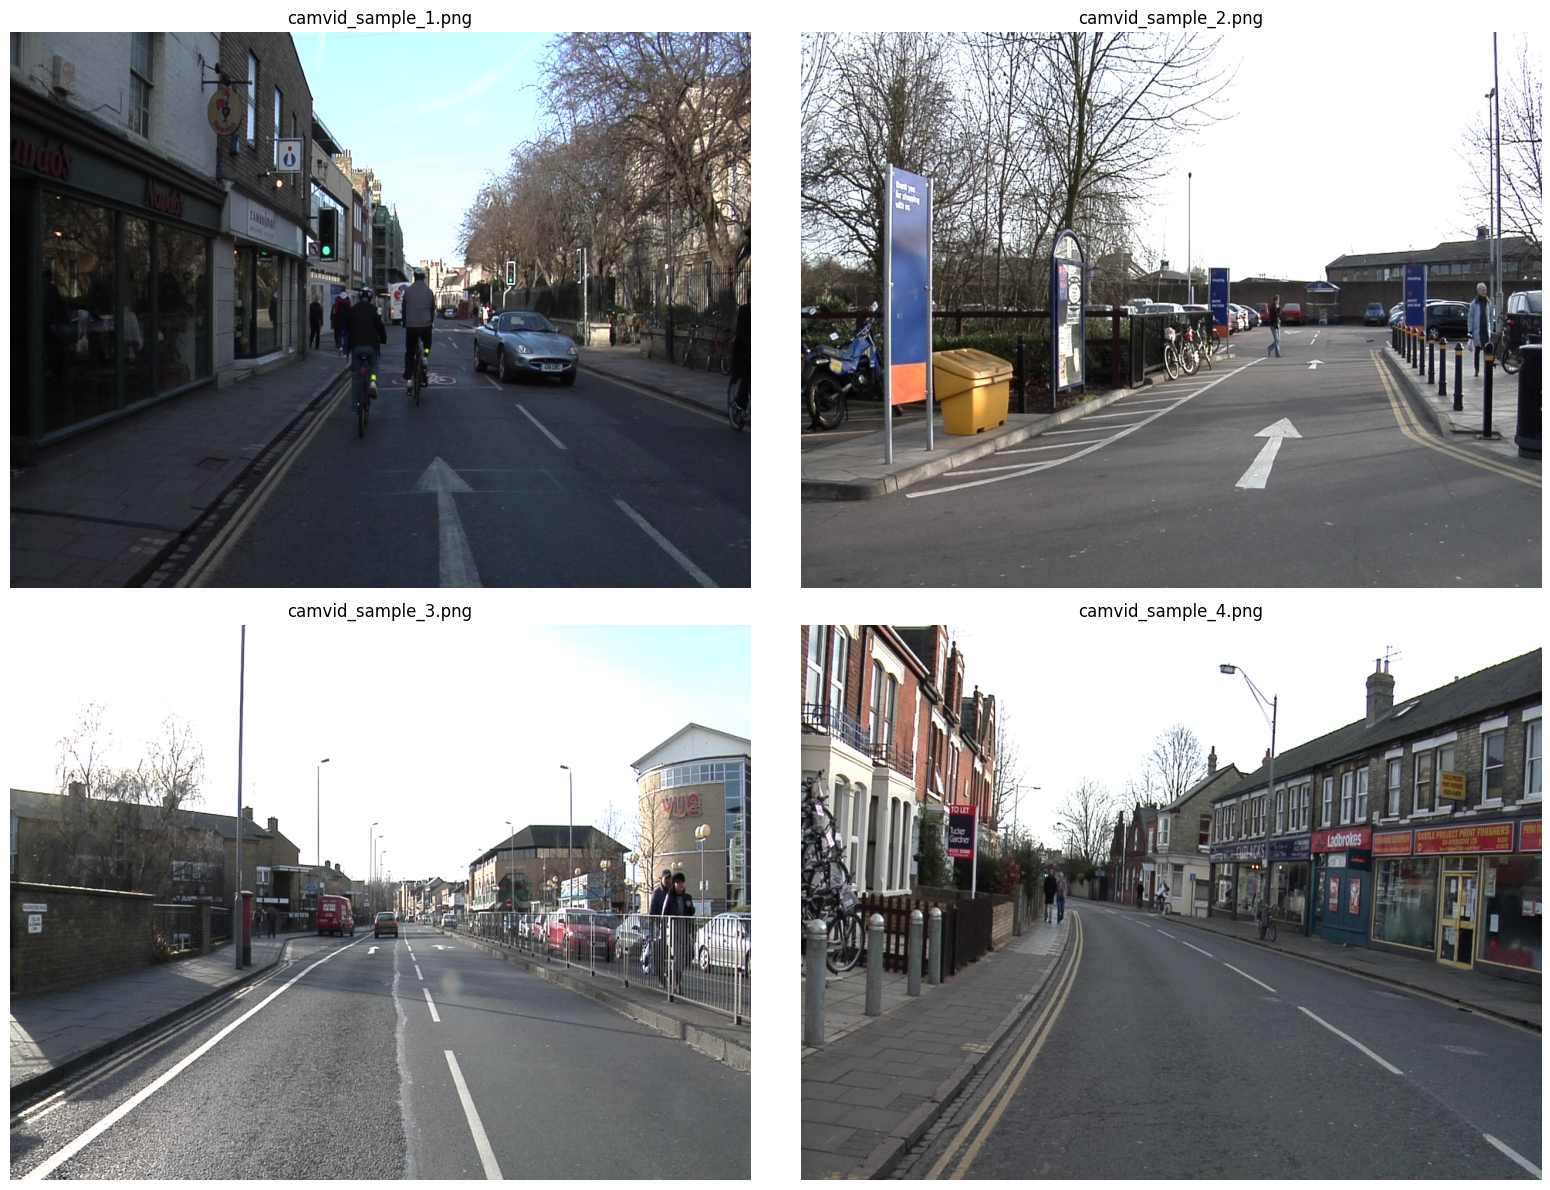

In [23]:
image_paths = sorted(glob.glob(os.path.join(SAMPLE_DIR, "*.png")))
print("Cantidad de imágenes:", len(image_paths))
print("Rutas:", image_paths)


def load_image(image_path: str) -> np.ndarray:
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"No pude leer la imagen: {image_path}")

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image.astype(np.float32) / 255.0

    # [H, W, 3] -> [1, H, W, 3]
    return np.expand_dims(image, axis=0)


images = []

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))
for idx, axis in enumerate(ax.flat):
    img = load_image(image_paths[idx])
    images.append(img)
    axis.imshow(img[0])
    axis.set_title(os.path.basename(image_paths[idx]))
    axis.axis("off")

plt.tight_layout()


## 4) Mapa de clases (CamVid)

`class_index` mapea cada **id de clase** a:
- un color **RGB** , y
- un nombre legible.

Esto lo usamos al final para pintar la máscara.


In [24]:
class_index = \
    {
         0: [(64, 128, 64),  'Animal'],
         1: [(192, 0, 128),  'Arco'],
         2: [(0, 128, 192),  'Ciclista'],
         3: [(0, 128, 64),   'Puente'],
         4: [(128, 0, 0),    'Edificio'],
         5: [(64, 0, 128),   'Auto'],
         6: [(64, 0, 192),   'Carrito/Equipaje/Cochecito'],
         7: [(192, 128, 64), 'Niño/a'],
         8: [(192, 192, 128),'Columna/Poste'],
         9: [(64, 64, 128),  'Cerca'],
        10: [(128, 0, 192),  'Marcas de carril (conducible)'],
        11: [(192, 0, 64),   'Marcas de carril (no conducible)'],
        12: [(128, 128, 64), 'Texto (varios)'],
        13: [(192, 0, 192),  'Moto/Scooter'],
        14: [(128, 64, 64),  'Otros en movimiento'],
        15: [(64, 192, 128), 'Tope de estacionamiento'],
        16: [(64, 64, 0),    'Peatón'],
        17: [(128, 64, 128), 'Ruta/Calzada'],
        18: [(128, 128, 192),'Banquina'],
        19: [(0, 0, 192),    'Vereda'],
        20: [(192, 128, 128),'Señal/Símbolo'],
        21: [(128, 128, 128),'Cielo'],
        22: [(64, 128, 192), 'SUV/Pickup/Camioneta'],
        23: [(0, 0, 64),     'Cono de tránsito'],
        24: [(0, 64, 64),    'Semáforo'],
        25: [(192, 64, 128), 'Tren'],
        26: [(128, 128, 0),  'Árbol'],
        27: [(192, 128, 192),'Camión/Colectivo'],
        28: [(64, 0, 64),    'Túnel'],
        29: [(192, 192, 0),  'Vegetación (varia)'],
        30: [(0, 0, 0),      'Vacío'],
        31: [(64, 192, 0),   'Pared']
    }


## 5) Cargar el modelo (TensorFlow Hub)

Voy a usar **HRNet** (High-Resolution Network) ya entrenado para CamVid.
No tenemos que entrenar nada, es decir solo **cargar y predecir**.


In [26]:
MODEL_HANDLE = "https://tfhub.dev/google/HRNet/camvid-hrnetv2-w48/1"

print("Cargando modelo...")
model = hub.load(MODEL_HANDLE)
print("Modelo cargado")

Cargando modelo...
Modelo cargado


## 6) Inferencia en una imagen + post-procesado

El modelo devuelve una máscara con **muchos canales** (uno por clase).
Generalmente viene así:
- shape tipo **[1, H, W, 33]** (incluye *background*)
- nosotros nos quedamos con las **32 clases** reales y luego hacemos `argmax` por pixel.


In [27]:
# Probamos con la primera imagen
raw = model.predict(images[0])
raw = raw.numpy()

print("Salida cruda (raw) shape:", raw.shape)

# Si viene con background (33 canales) lo sacamos
if raw.shape[-1] == 33:
    raw = raw[:, :, :, 1:]

# Sacamos batch dimension [1, H, W, 32] -> [H, W, 32]
probs = np.squeeze(raw)
print("Probs shape (sin batch):", probs.shape)


Salida cruda (raw) shape: (1, 720, 960, 33)
Probs shape (sin batch): (720, 960, 32)


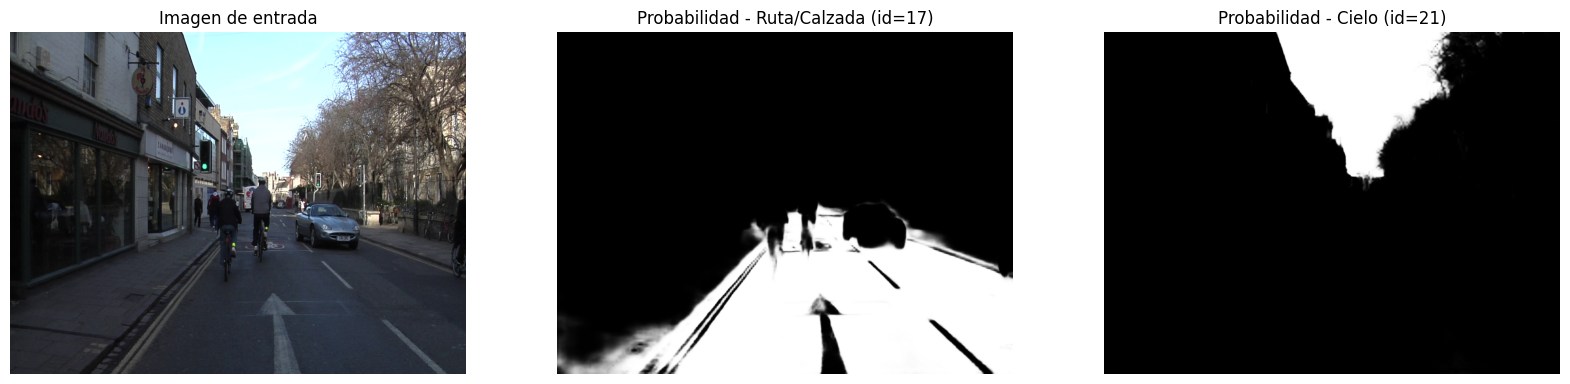

In [28]:
# Miramos 2 canales por ejemplo (Ruta y Cielo)

plt.figure(figsize=(20, 6))

plt.subplot(1, 3, 1)
plt.title("Imagen de entrada")
plt.imshow(images[0][0])
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Probabilidad - Ruta/Calzada (id=17)")
plt.imshow(probs[:, :, 17], cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Probabilidad - Cielo (id=21)")
plt.imshow(probs[:, :, 21], cmap='gray')
plt.axis('off')

plt.show()


### 6.1) Pasar de probabilidades a clases (argmax)

A cada pixel se le asigna una sola clase, la de mayor probabilidad.


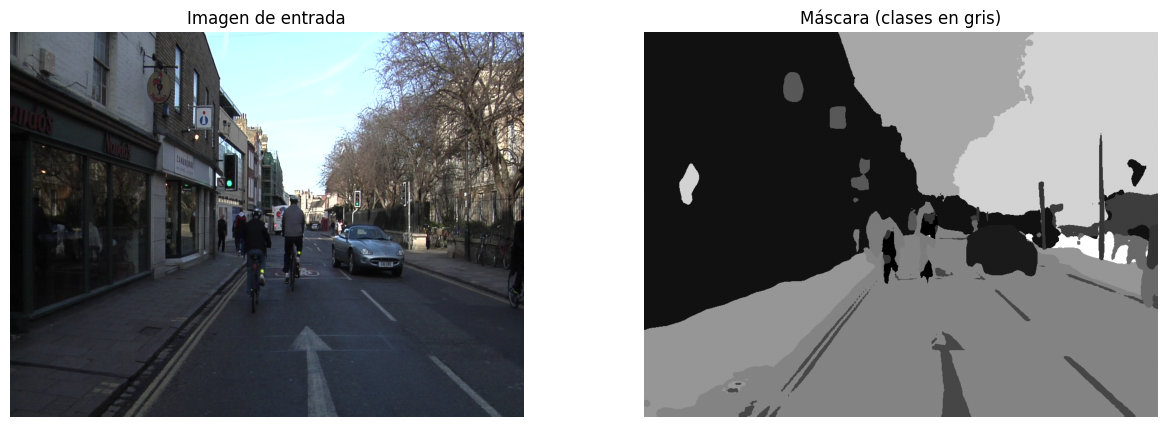

In [29]:
pred_mask_class = np.argmax(probs, axis=-1).astype(np.uint8)

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.title('Imagen de entrada')
plt.imshow(images[0][0])
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Máscara (clases en gris)')
plt.imshow(pred_mask_class, cmap='gray')
plt.axis('off')

plt.show()


## 7) Pasar la máscara a color (RGB)

Para visualizar mejor, mapeo cada id de clase al color RGB definido en `class_index`.


In [30]:
def class_to_rgb(mask_class: np.ndarray, class_index: dict) -> np.ndarray:
    # Creamos canales RGB
    r_map = np.zeros_like(mask_class, dtype=np.uint8)
    g_map = np.zeros_like(mask_class, dtype=np.uint8)
    b_map = np.zeros_like(mask_class, dtype=np.uint8)

    # Asignamos un color RGB a cada pixel según su clase
    for class_id in range(len(class_index)):
        index = mask_class == class_id
        r_map[index] = class_index[class_id][0][0]
        g_map[index] = class_index[class_id][0][1]
        b_map[index] = class_index[class_id][0][2]

    return np.stack([r_map, g_map, b_map], axis=2)


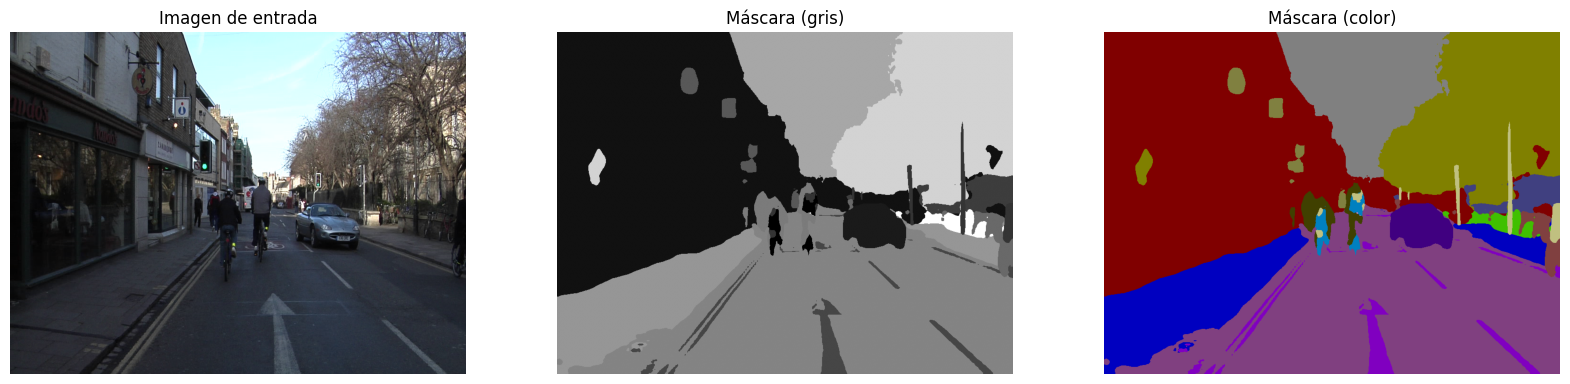

In [31]:
pred_mask_rgb = class_to_rgb(pred_mask_class, class_index)

plt.figure(figsize=(20, 8))

plt.subplot(1, 3, 1)
plt.title('Imagen de entrada')
plt.imshow(images[0][0])
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Máscara (gris)')
plt.imshow(pred_mask_class, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Máscara (color)')
plt.imshow(pred_mask_rgb)
plt.axis('off')

plt.show()


## 8) Funciones auxiliares (overlay + inferencia en lote)

Para no repetir los pasos anteriores creamos 3 funciones de utilidad:
- `image_overlay`: superpone la máscara RGB sobre la imagen.
- `run_inference`: corre inferencia sobre varias imágenes y muestra resultados.
- `plot_color_legend`: muestra la leyenda de colores/clases.


In [33]:
def image_overlay(image: np.ndarray, seg_map_rgb: np.ndarray) -> np.ndarray:

    alpha = 1.0  # Transparencia imagen original
    beta = 0.6   # Transparencia máscara
    gamma = 0.0 # Escalar

    base = (image * 255.0).astype(np.uint8)
    mask_bgr = cv2.cvtColor(seg_map_rgb, cv2.COLOR_RGB2BGR)

    out = cv2.addWeighted(base, alpha, mask_bgr, beta, gamma)
    out = cv2.cvtColor(out, cv2.COLOR_BGR2RGB)

    return out


In [35]:
def run_inference(images: list, model, class_index: dict) -> None:
    for img in images:
        raw = model.predict(img).numpy()

        if raw.shape[-1] == 33:
            raw = raw[:, :, :, 1:]

        probs = np.squeeze(raw)  # [H, W, 32]
        mask_class = np.argmax(probs, axis=-1).astype(np.uint8)
        mask_rgb = class_to_rgb(mask_class, class_index)

        overlay = image_overlay(img[0], mask_rgb)

        fig = plt.figure(figsize=(20, 12))

        ax1 = fig.add_subplot(1, 3, 1)
        ax1.imshow(img[0])
        ax1.set_title('Imagen de entrada')
        ax1.axis('off')

        ax2 = fig.add_subplot(1, 3, 2)
        ax2.imshow(mask_rgb)
        ax2.set_title('Máscara (color)')
        ax2.axis('off')

        ax3 = fig.add_subplot(1, 3, 3)
        ax3.imshow(overlay)
        ax3.set_title('Overlay (máscara sobre imagen)')
        ax3.axis('off')

        plt.show()


In [36]:
def plot_color_legend(class_index: dict) -> None:
    # Extraigo colores y etiquetas
    color_array = np.array([[v[0][0], v[0][1], v[0][2]] for v in class_index.values()], dtype=np.uint8)
    class_labels = [val[1] for val in class_index.values()]

    fig, ax = plt.subplots(nrows=2, ncols=16, figsize=(20, 3))
    plt.subplots_adjust(wspace=0.5, hspace=0.01)

    for i, axis in enumerate(ax.flat):
        axis.imshow(color_array[i][None, None, :])
        axis.set_title(class_labels[i], fontsize=8)
        axis.axis('off')

    plt.show()


## 9) Predicciones sobre las imágenes de ejemplo

Debajo dejo las leyendas de cada clase con su respectivo color y llamamos a `run_inference`

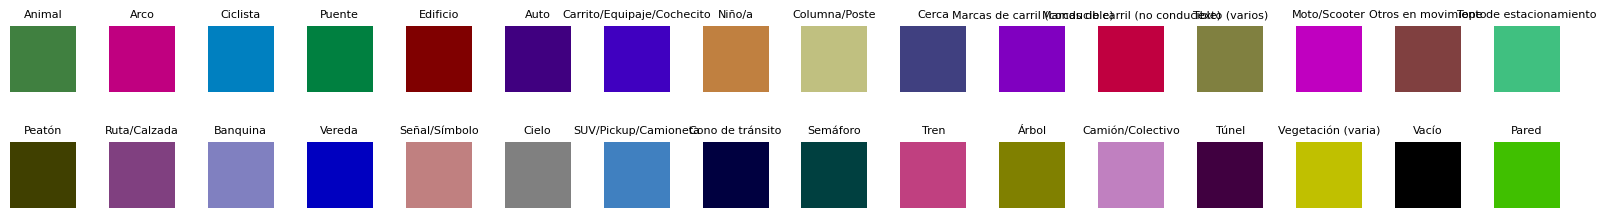

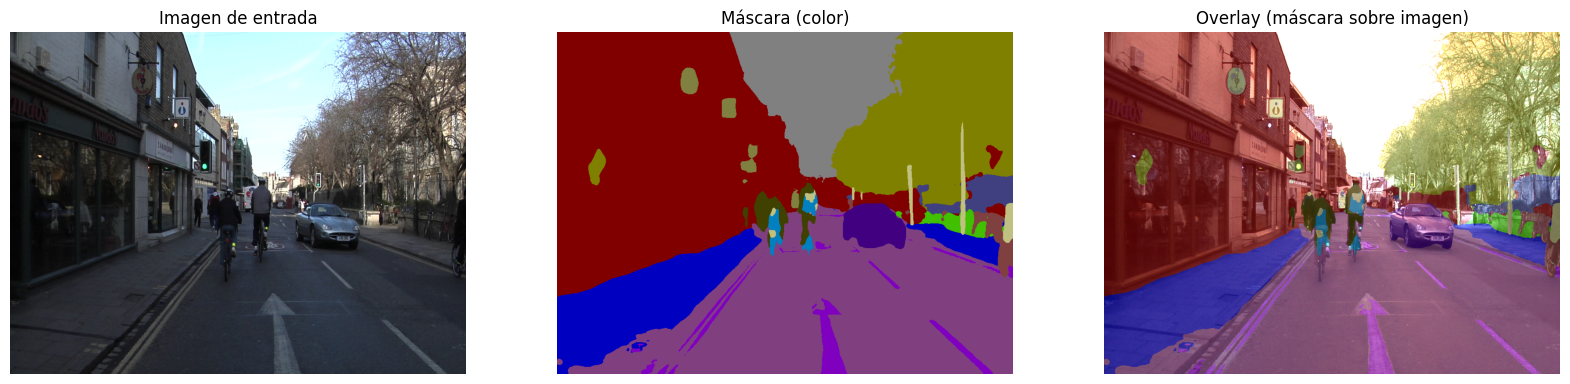

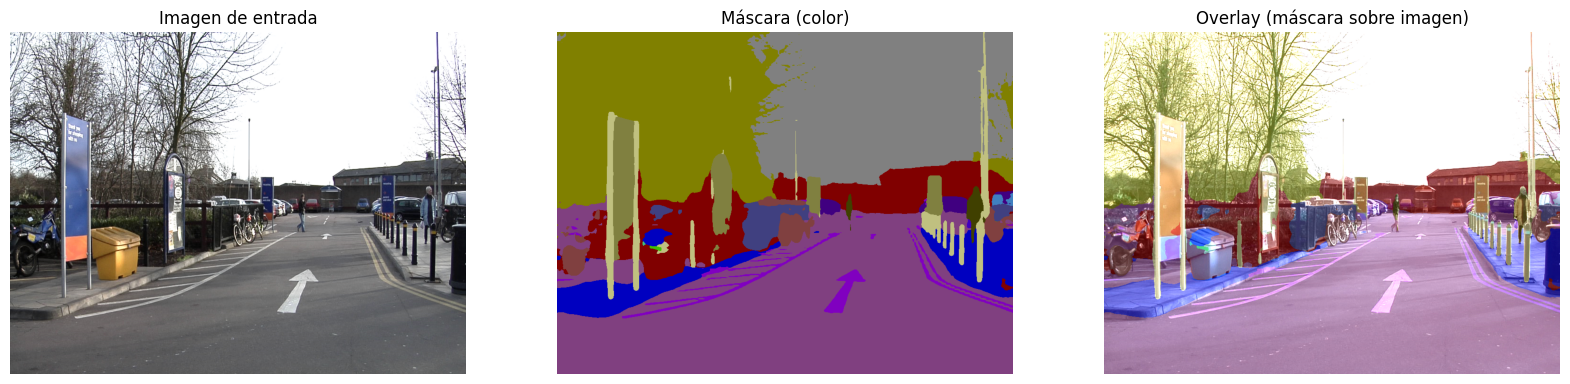

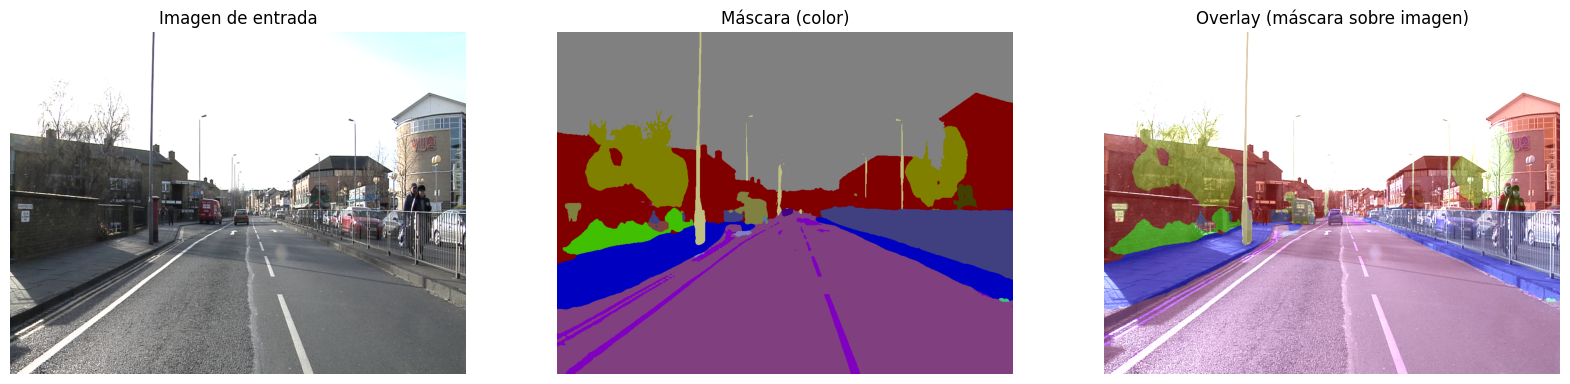

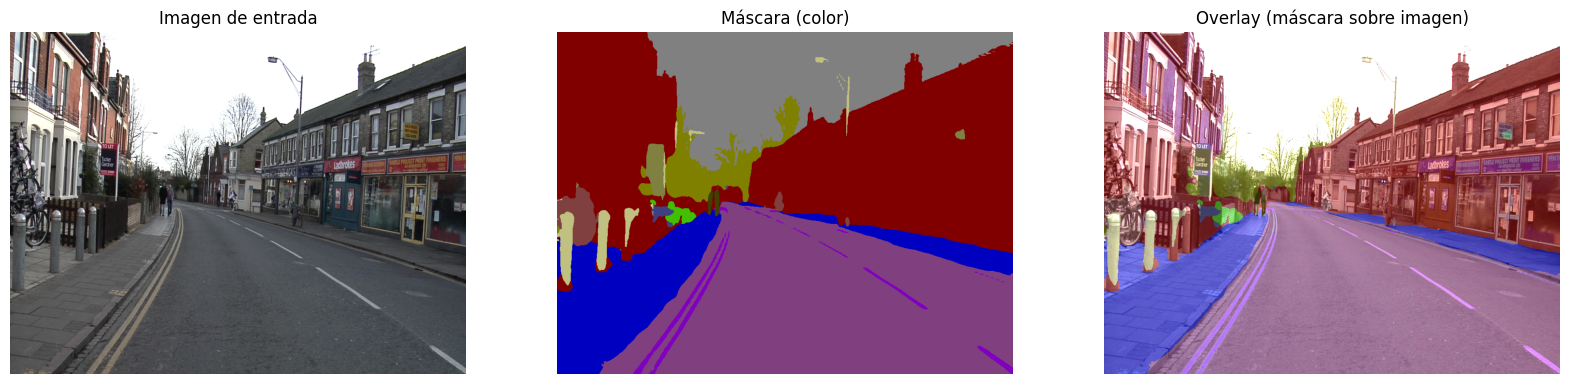

In [38]:
plot_color_legend(class_index)
run_inference(images, model, class_index)
